In [1]:
# pip install surprise

In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader
from surprise import SVD
import emoji
import pickle
# from surprise import evaluate
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rake_nltk import Rake

import warnings; warnings.simplefilter('ignore')

In [44]:
movie_df = pd. read_csv('data/movies_metadata.csv')
movie_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [45]:
movie_df['original_title']=movie_df['original_title'].str.lower() 
movie_df['original_title']

0                          toy story
1                            jumanji
2                   grumpier old men
3                  waiting to exhale
4        father of the bride part ii
                    ...             
45461                        رگ خواب
45462            siglo ng pagluluwal
45463                       betrayal
45464            satana likuyushchiy
45465                       queerama
Name: original_title, Length: 45466, dtype: object

In [46]:
# Selecting all the genres 

movie_df['genres'] = movie_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [47]:
# get movie release year
movie_df['year'] = pd.to_datetime(movie_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [48]:
# Evl Vote count 

vote_count = movie_df[movie_df['vote_count'].notnull()]['vote_count'].astype('int')

vote_avg = movie_df[movie_df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_avg.mean()
C

5.244896612406511

In [49]:
m = vote_count.quantile(0.95)
m

434.0

In [50]:
qualified = movie_df[(movie_df['vote_count'] >= m) & (movie_df['vote_count'].notnull()) & (movie_df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [51]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [52]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)

In [53]:
qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)

In [54]:
qualified.head(1)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588


In [55]:
s = movie_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_movie_df = movie_df.drop('genres', axis=1).join(s)


In [56]:
def build_chart(genre, percentile=0.85):
    df = gen_movie_df[gen_movie_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [57]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


## Content Based Recommender System

In [58]:
links_small = pd.read_csv('data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [59]:
movie_df = movie_df.drop([19730, 29503, 35587])


In [60]:
#Check EDA Notebook for how and why I got these indices.
movie_df['id'] = movie_df['id'].astype('int')

In [61]:
#Check EDA Notebook for how and why I got these indices.
movie_df['id'] = movie_df['id'].astype('int')

In [62]:
movie_df_ex = movie_df[movie_df['id'].isin(links_small)]
movie_df_ex.shape

(9099, 25)

In [63]:
movie_df_ex['tagline'].head(10)

0                                                  NaN
1            Roll the dice and unleash the excitement!
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
5                             A Los Angeles Crime Saga
6    You are cordially invited to the most surprisi...
7                               The Original Bad Boys.
8                           Terror goes into overtime.
9                 No limits. No fears. No substitutes.
Name: tagline, dtype: object

## Tags based 

In [64]:
movie_df_ex['tagline'] = movie_df_ex['tagline'].fillna('')
movie_df_ex['description'] = movie_df_ex['overview'] + movie_df_ex['tagline']
movie_df_ex['description'] = movie_df_ex['description'].fillna('')

In [165]:
movie_df_ex = movie_df_ex.sort_values('title', ascending=False).drop_duplicates('title').sort_index()

In [166]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# clean the text dataframe
def text_cleaning(text):
    text = text.lower()
        
    text = re.sub(r'http.?:\/\/\S+','',text) #remove links
    text = emoji.demojize(text, delimiters=("", "")) 
  # text = text.encode("ascii", errors="ignore").decode()
 
    text=re.sub(r'@[A-Za-z0-9]+','',text) #removes mentions
    text=re.sub(r'#','',text)#remove hashtag
    text = re.sub(r'RT[\s]','',text) #remove RT
    text = re.sub(r'http?:\/\/\S+','',text) #remove links
    text = re.sub(r"br", " ", text)
    text = re.sub(r"_", " ", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", " ", text)
    text=re.sub(r'\'','',text)
    text=re.sub(r'\"','',text)
    text=re.sub(r'\“','',text)
    text=re.sub(r'\”','',text)
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words1 = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    stop_words.discard("not")

    words1 = [w for w in words1 if not w in stop_words]
    words1 = ' '.join(words1)
  # print(words1)
  # words1 = " ".join(w for w in nltk.wordpunct_tokenize(words1) if w.lower() in words or not w.isalpha())
  # words1 = [w for w in words1 if  w in words.words()]
  # final = ' '.join(words1)
    final=[lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(words1)]
    final = ' '.join(final)
    return final

In [167]:
movie_df_ex['description'] = movie_df_ex['description'].apply(text_cleaning)

In [168]:
# movie_df_ex.to_csv('tags_recom.csv',index=False)

In [169]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
c = CountVectorizer()
tfidf_mtx = c.fit_transform(movie_df_ex['description'])

In [170]:
tfidf_mtx.shape

(8809, 26779)

In [171]:
cosine_sim = linear_kernel(tfidf_mtx, tfidf_mtx)

In [172]:
cosine_sim[0]

array([51.,  1.,  0., ...,  1.,  0.,  1.])

In [173]:
movie_df_ex

,level_0,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,led woody andy toy live happily room andy birt...
1,1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,sibling judy peter discover enchanted board ga...
2,2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,family wedding reignites ancient feud next doo...
3,3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,cheated mistreated stepped woman holding eath ...
4,4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,george bank recovered daughter wedding receive...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9093,9093,9093,False,NaN,15050000,"[Adventure, Drama, History, Romance]",NaN,402672,tt3859980,hi,...,155.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,,Mohenjo Daro,False,6.7,26.0,2016,village lad sarman drawn big bad mohenjo daro ...
9094,9094,9094,False,NaN,15000000,"[Action, Adventure, Drama, Horror, Science Fic...",NaN,315011,tt4262980,ja,...,120.0,"[{'iso_639_1': 'it', 'name': 'Italiano'}, {'is...",Released,A god incarnate. A city doomed.,Shin Godzilla,False,6.6,152.0,2016,mind behind evangelion come hit larger life ma...
9095,9095,9095,False,NaN,0,"[Documentary, Music]",http://www.thebeatlesliveproject.com/,391698,tt2531318,en,...,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The band you know. The story you don't.,The Beatles: Eight Days a Week - The Touring Y...,False,7.6,92.0,2016,band stormed europe conquered america ground e...
9096,9096,9096,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",16000000,"[Adventure, Fantasy, Animation, Action, Family]",http://movies.warnerbros.com/pk3/,10991,tt0235679,ja,...,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,False,6.0,144.0,2000,molly hale sadness father disappearance get un...


In [174]:
movie_df_ex.to_csv('tags_recom.csv',index=False)

In [161]:
movie_df_ex=movie_df_ex.drop(['level_0', 'index'], axis=1)

In [162]:
movie_df_ex = movie_df_ex.reset_index()
titles = movie_df_ex['title']
indices = pd.Series(movie_df_ex.index, index=movie_df_ex['title'])

In [163]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
c  = CountVectorizer()
tfidf_mtx = c.fit_transform(movie_df_ex['description'])
cosine_sim = linear_kernel(tfidf_mtx, tfidf_mtx)
movie_df_ex = movie_df_ex.reset_index()
titles = movie_df_ex['title']
indices = pd.Series(movie_df_ex.index, index=movie_df_ex['title'])
def recommendations_tags(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [158]:
recommendations_tags('2012').head(10)

6250                        Left Behind III: World at War
5061                                           Cool World
4541                                             The Core
8047                 Dragon Ball Z: The World's Strongest
1250                                         Men in Black
7122                                                Ponyo
7220    Fullmetal Alchemist the Movie: Conqueror of Sh...
61                                               Bio-Dome
5592                           Team America: World Police
6985                                           Death Note
Name: title, dtype: object

In [76]:
recommendations_tags('Inception').head(10)

6882                             Semi-Pro
2118                  Son of Frankenstein
807                           The Chamber
5162    The Rolling Stones: Gimme Shelter
1825                                 2010
2097                           Black Mask
4023                        Stolen Summer
4755                         Taking Sides
5728                          Spider Baby
4794    Lagaan: Once Upon a Time in India
Name: title, dtype: object

## Metadata Based Recommender

In [186]:
credits = pd.read_csv('data/credits.csv')
keywords = pd.read_csv('data/keywords.csv')

In [187]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movie_df['id'] = movie_df['id'].astype('int')

In [188]:
movie_df.shape

(96052, 37)

In [189]:
movie_df = movie_df.merge(credits, on='id')
movie_df = movie_df.merge(keywords, on='id')

In [190]:
smovie_df = movie_df[movie_df['id'].isin(links_small)]
smovie_df.shape

(44439, 40)

In [191]:
smovie_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,keywords_y,cast_x,crew_x,keywords_x,cast_y,crew_y,keywords_y,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,toy story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,jumanji,When siblings Judy and Peter discover an encha...,...,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,grumpier old men,A family wedding reignites the ancient feud be...,...,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,waiting to exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,father of the bride part ii,Just when George Banks has recovered from his ...,...,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

Crew: From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.
Cast: Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 3 actors that appear in the credits list.

In [192]:
smovie_df['cast'] = smovie_df['cast'].apply(literal_eval)
smovie_df['crew'] = smovie_df['crew'].apply(literal_eval)
smovie_df['keywords'] = smovie_df['keywords'].apply(literal_eval)
smovie_df['cast_size'] = smovie_df['cast'].apply(lambda x: len(x))
smovie_df['crew_size'] = smovie_df['crew'].apply(lambda x: len(x))

In [193]:
def get_directors(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [194]:
smovie_df['director'] = smovie_df['crew'].apply(get_directors)

In [195]:
smovie_df['cast'] = smovie_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smovie_df['cast'] = smovie_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [196]:
smovie_df['keywords'] = smovie_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

These are steps I follow in the preparation of my genres and credits data:

Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.
Mention Director 3 times to give it more weight relative to the entire cast.

In [197]:
smovie_df['cast'] = smovie_df['cast'].apply(lambda x: [str.lower(i.replace(" ", " ")) for i in x])

In [198]:
smovie_df['director'] = smovie_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", " ")))
smovie_df['director'] = smovie_df['director'].apply(lambda x: [x,x, x])

Keywords


We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [199]:
s = smovie_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [200]:
s = s.value_counts()
s[:5]

biography           4288
best friend         4163
pokémon             4097
woman director      2650
independent film    2650
Name: keyword, dtype: int64

In [201]:
s = s[s > 1]

In [202]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [203]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [204]:
smovie_df['keywords'] = smovie_df['keywords'].apply(filter_keywords)
smovie_df['keywords'] = smovie_df['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smovie_df['keywords'] = smovie_df['keywords'].apply(lambda x: [str.lower(i.replace(" ", " ")) for i in x])

In [205]:
smovie_df['soup'] = smovie_df['keywords'] + smovie_df['cast'] + smovie_df['director'] + smovie_df['genres']
smovie_df['soup'] = smovie_df['soup'].apply(lambda x: ' '.join(x))

In [206]:
smovie_df['soup'][0]

'jealousi toy boy friendship friend rivalri boy next door new toy toy comes to lif tom hanks tim allen don rickles john lasseter john lasseter john lasseter Animation Comedy Family'

In [207]:
smovie_df = smovie_df.sort_values('title', ascending=False).drop_duplicates('title').sort_index()

In [208]:
smovie_df.to_csv('content_recom.csv',index=False)

In [51]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smovie_df['soup'])

In [52]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [53]:
smovie_df = smovie_df.reset_index()
titles = smovie_df['title']
indices = pd.Series(smovie_df.index, index=smovie_df['title'])

In [54]:
get_recommendations('Back to the Future').head(10)

1590     Back to the Future Part II
1591    Back to the Future Part III
3990                      Used Cars
3239                      Cast Away
9031                       The Walk
5689              The Polar Express
2630              Death Becomes Her
2414        Who Framed Roger Rabbit
6892                        Beowulf
1274                        Contact
Name: title, dtype: object

Popularity and Ratings

I will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of  m
 , we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [177]:
smovie_df.head()

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,toy story,...,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousi, toy, boy, friendship, friend, rival...",13,106,"[johnlasseter, johnlasseter, johnlasseter]",jealousi toy boy friendship friend rivalri boy...
1,1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,jumanji,...,6.9,2413.0,1995,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgam, disappear, basedonchildren'sbook, n...",26,16,"[joejohnston, joejohnston, joejohnston]",boardgam disappear basedonchildren'sbook newho...
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,grumpier old men,...,6.5,92.0,1995,"[waltermatthau, jacklemmon, ann-margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fish, bestfriend, duringcreditssting]",7,4,"[howarddeutch, howarddeutch, howarddeutch]",fish bestfriend duringcreditssting waltermatth...
3,3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,waiting to exhale,...,6.1,34.0,1995,"[whitneyhouston, angelabassett, lorettadevine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[basedonnovel, interracialrelationship, single...",10,10,"[forestwhitaker, forestwhitaker, forestwhitaker]",basedonnovel interracialrelationship singlemot...
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,father of the bride part ii,...,5.7,173.0,1995,"[stevemartin, dianekeaton, martinshort]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[babi, midlifecrisi, confid, age, daughter, mo...",12,7,"[charlesshyer, charlesshyer, charlesshyer]",babi midlifecrisi confid age daughter motherda...


In [120]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smovie_df['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smovie_df = smovie_df.reset_index()
titles = smovie_df['title']
indices = pd.Series(smovie_df.index, index=smovie_df['title'])

In [55]:


def recommendations_content(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smovie_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [100]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [142]:
def txt_clean(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = simple_stemmer(text)
    text = remove_stopwords(text)
    print(text)
#     text = simple_stemmer(text)
    op = cv.transform(norm_test_reviews)
    return op

# print(txt_clean('hello i\'m sudeep he\'s ads ksksk'))
a=txt_clean('hello good movies')
adc=lr.predict(a)
print(adc.shape)
    
    

hello good movi
(10000,)


In [101]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [102]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

In [103]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [104]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'he', 'who', 'more', "hasn't", 'here', 'do', 'they', "you're", "mustn't", 'when', 'll', 'same', 'be', 'which', 'or', 'this', 'doesn', "haven't", 'the', 'than', 'o', 'didn', 'herself', 't', 'only', 'on', 'was', 'having', 'once', 'don', 'me', "won't", 'aren', 'any', 'hers', 'by', 'yours', 'such', 'theirs', 'further', 'out', "you've", 'after', 'their', 'themselves', 'why', 'can', "isn't", 'to', "it's", 'with', 'shan', 'that', 'doing', 'his', 'yourselves', 'an', 'ma', 'up', 'during', 's', 'its', 'haven', "don't", 'until', 'so', 'ourselves', 'there', 'won', 'should', 'what', 'how', 'while', 'just', "hadn't", 'wouldn', 'couldn', 'isn', 'y', "you'll", "mightn't", 'will', 'itself', 'does', 'a', 'for', 'she', 'off', 'were', 'under', 'weren', 'against', "couldn't", 'it', 'being', 'if', "she's", 'our', 'down', 'did', 'in', 'mustn', "needn't", "wouldn't", 'you', 'am', 'each', 'very', 've', 'hadn', 'nor', "wasn't", "that'll", 'too', 'where', 'my', 'because', 'most', 'd', 'not', 'him', 'is', 'i', '

In [ ]:
movie_df_ex.to_csv('tags_data.csv',index=False)

In [56]:
recommendations_content('2 Fast 2 Furious').head(10)

,title,vote_count,vote_average,year,wr
4863,Boyz n the Hood,377,7,1991,6.060771
8408,Fast & Furious 6,5282,6,2013,5.942667
3481,The Fast and the Furious,3485,6,2001,5.916378
7266,Fast & Furious,2426,6,2009,5.885414
6518,The Fast and the Furious: Tokyo Drift,1749,6,2006,5.849879
7133,RockNRolla,851,6,2008,5.744969
6261,Four Brothers,617,6,2005,5.688188
8026,Bullet to the Head,490,5,2013,5.115027
7997,Abduction,987,5,2011,5.074796
9162,London Has Fallen,1656,5,2016,5.050854


## collaborative

In [57]:
reader = Reader()

In [58]:
ratings = pd.read_csv('data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [59]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# data.split(n_folds=5)
# Run 5-fold cross-validation and print results
# We'll use the famous SVD algorithm.
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
# cross_validate('kfold', data, measures=['RMSE'], cv=5)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8987  0.8867  0.8966  0.9008  0.9007  0.8967  0.0052  
MAE (testset)     0.6924  0.6835  0.6898  0.6928  0.6925  0.6902  0.0035  
Fit time          2.39    2.36    2.35    2.32    2.29    2.34    0.03    
Test time         0.06    0.06    0.12    0.05    0.05    0.07    0.03    


{'test_rmse': array([0.89874712, 0.88667559, 0.89663848, 0.90084201, 0.90066257]),
 'test_mae': array([0.69237615, 0.68352427, 0.68975188, 0.6928312 , 0.69251147]),
 'fit_time': (2.387939214706421,
  2.362353801727295,
  2.349463939666748,
  2.321215867996216,
  2.289198875427246),
 'test_time': (0.05748391151428223,
  0.05520009994506836,
  0.11863017082214355,
  0.052247047424316406,
  0.052336931228637695)}

In [60]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [61]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [62]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.531436433774873, details={'was_impossible': False})

## Hybrid Recommender

In [63]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [64]:
id_map = pd.read_csv('data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smovie_df[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [65]:
indices_map = id_map.set_index('id')

In [66]:
def recommendations_hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smovie_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [67]:
recommendations_hybrid(1, 'Forrest Gump')

,title,vote_count,vote_average,year,id,est
1041,Back to the Future,6239.0,8.0,1985,105,3.326153
3628,The Big Picture,24.0,5.9,1989,45225,2.986013
1274,Contact,1338.0,7.2,1997,686,2.886843
2414,Who Framed Roger Rabbit,1466.0,7.2,1988,856,2.839869
1933,Romancing the Stone,477.0,6.6,1984,9326,2.803594
9031,The Walk,1151.0,6.9,2015,285783,2.797665
8556,Geography Club,55.0,6.5,2013,197033,2.766784
6762,Sylvia Scarlett,12.0,5.0,1935,31866,2.736749
1590,Back to the Future Part II,3926.0,7.4,1989,165,2.731494
3052,What Lies Beneath,504.0,6.3,2000,2655,2.727072


## Sentiment analysis

In [132]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


Init Plugin
Init Graph Optimizer
Init Kernel


In [69]:
#importing the training data
imdb_data=pd.read_csv('data/IMDBDataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [70]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


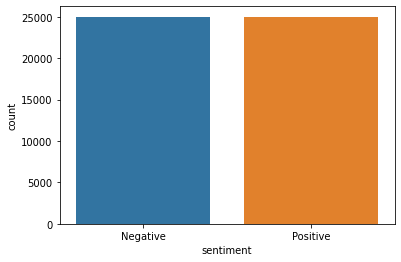

In [71]:
 # visualize the target variable
g = sns.countplot(imdb_data['sentiment'])
g.set_xticklabels(['Negative','Positive'])
plt.show()

##### Spliting the training dataset

In [72]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


### Text normalization

In [93]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# clean the text dataframe
def text_cleaning(text):
    text = text.lower()
        
    text = re.sub(r'http.?:\/\/\S+','',text) #remove links
    text = emoji.demojize(text, delimiters=("", "")) 
  # text = text.encode("ascii", errors="ignore").decode()
 
    text=re.sub(r'@[A-Za-z0-9]+','',text) #removes mentions
    text=re.sub(r'#','',text)#remove hashtag
    text = re.sub(r'RT[\s]','',text) #remove RT
    text = re.sub(r'http?:\/\/\S+','',text) #remove links
    text = re.sub(r"br", " ", text)
    text = re.sub(r"_", " ", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", " ", text)
    text=re.sub(r'\'','',text)
    text=re.sub(r'\"','',text)
    text=re.sub(r'\“','',text)
    text=re.sub(r'\”','',text)
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words1 = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    stop_words.discard("not")

    words1 = [w for w in words1 if not w in stop_words]
    words1 = ' '.join(words1)
  # print(words1)
  # words1 = " ".join(w for w in nltk.wordpunct_tokenize(words1) if w.lower() in words or not w.isalpha())
  # words1 = [w for w in words1 if  w in words.words()]
  # final = ' '.join(words1)
    final=[lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(words1)]
    final = ' '.join(final)
    return final

In [94]:
imdb_data['review'] =  imdb_data['review'].apply(text_cleaning)

In [95]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]



'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz utality unflinching scene violence set right word go trust not show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience wat

In [96]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]


'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz utality unflinching scene violence set right word go trust not show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience wat

In [97]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watching piece cinematic garbage took least page find somebody else think appallingly unfunny montage acme humour indeed era least funny set sketch comedy ever seen till come along half skit already done infinitely better act monty python woody allen say nice piece animation last second highlight film would still not get close summing mindless drivel ridden waste minute seminal comedy world seminal really mean semen scatological humour world scat actually feces precursor joke mean handbook not comedy tit bum odd beaver nice pubescent boy least one hand free found playboy exists give eak early way sketch comedy going back least ten year prior way could even forgive film even made gunpoint retro hardly sketch clown subtly perverting child may cutting edge circle could actually funny come really quite sad kept going throughout entire minute sheer belief may saved genuinely funny skit end gave film lower score recommend insomniac coma patient perhaps people suffering lockjaw j

In [98]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6088764)
BOW_cv_test: (10000, 6088764)


In [99]:
pickle.dump(cv, open('countVector.pkl', 'wb'))

In [100]:
cv_test_reviews

<10000x6088764 sparse matrix of type '<class 'numpy.int64'>'
	with 195688 stored elements in Compressed Sparse Row format>

In [101]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6088764)
Tfidf_test: (10000, 6088764)


In [102]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [103]:
 #Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score,accuracy_score
clf = naive_bayes.MultinomialNB()
clf.fit(tv_train_reviews,train_sentiments)

MultinomialNB()

In [185]:
accuracy_score(test_sentiments,clf.predict(tv_test_reviews))*100

74.26

In [104]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [105]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [106]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7421
lr_tfidf_score : 0.7413


In [107]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      4993
    Negative       0.74      0.74      0.74      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

              precision    recall  f1-score   support

    Positive       0.73      0.76      0.75      4993
    Negative       0.75      0.72      0.74      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [90]:
 filename = 'Sentiment_model.pkl'
pickle.dump(lr, open(filename, 'wb'))